In [1]:
import uproot4 as uproot
print(uproot.__version__)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Run this once to install mplhep:
#!pip install mplhep --user 
#!pip install --user awkward1
import mplhep as hep
import pandas as pd
import awkward as ak
#!pip install pyarrow --user
# Load style sheet
plt.style.use(hep.style.ATLAS)  # or ATLAS/LHCb

import logging

0.1.2


In [2]:
# test_crossDivNrgCrab_35mRad_18x275_v1.xxxx.hcal_clustering.root
# Load a single file and print the branches of the TTree
# file = uproot.open("EIC/reconstruction_benchmarks/rec_electron.root")
# file.keys()

# tree = file["events"]
# print(tree.num_entries)
# branches = tree.keys()
# for branch in branches:
#     if branch.find("Cluster") != -1:
#         print(branch)

['events;1', 'metadata;1']

In [ ]:
class HistManager:
    def __init__(self):
        self.histograms = {}
    

    def clear(self):
        self.histograms = {}

    def add(self, df, name, x, cuts=[], nbins=100, range=[0,1], density=False):
        
        
        #branch = df[varString].ravel()
    
        mask = np.ones(len(x), dtype=bool)

        for cut in cuts:
            if len(mask) != len(cut):
                print("Error: existing bitmask and new cut bitmask have different sizes!")

            mask = np.bitwise_and(np.array(mask), np.array(cut))
        
        if name not in self.histograms:
            print(f"Creating histogram named {name} ... ")
            self.histograms[name] = np.histogram(x[mask], nbins, range, density=density)
        else:
            (hist, bins) = np.histogram(x[mask], nbins, range)
            newhist = np.sum([hist, self.histograms[name][0]], axis=0)
            self.histograms[name] = (newhist, self.histograms[name][1])
    
    def get_all(self):
        return self.histograms

    def get(self, name):
        return self.histograms[name]

    def get_hist(self, name):
        return self.histograms[name][0]
    
    def get_bins(self, name):
        return self.histograms[name][1]

def HCALEnergy(row, eta_range=[-1,1]):
    # Primary theta and phi
    primary_theta = row["PrimaryTheta"]
    primary_phi = row["PrimaryPhi"]
    
    primary_eta = -np.log(np.tan(primary_theta/2.0))
    
    if (primary_eta < eta_range[0] or primary_eta > eta_range[1]):
        return -1.0
    
    dRmax = 1.0
    TotalHCAL = 0.0

    for system in ["HcalBarrel", "HcalHadronEndcap", "HcalElectronEndcap"]:
        try:
            cl_energy = row[f"{system}Clusters.energy"]
            cl_theta  = row[f"{system}Clusters.polar.theta"]
            cl_phi    = row[f"{system}Clusters.polar.phi"]
            deltaR = np.sqrt( np.power(cl_theta - primary_theta,2) + np.power(cl_phi - primary_phi, 2))
            TotalHCAL += np.sum(cl_energy[deltaR < dRmax])
        except:
            pass

        
    return TotalHCAL

def ECALEnergy(row, eta_range=[-1,1]):
    # Primary theta and phi
    primary_theta = row["PrimaryTheta"]
    primary_phi = row["PrimaryPhi"]
    
    primary_eta = -np.log(np.tan(primary_theta/2.0))
    
    if (primary_eta < eta_range[0] or primary_eta > eta_range[1]):
        return -1.0
        
    dRmax = 1.0
    TotalECAL = 0.0
    
    for system in ["EcalBarrel", "EcalEndcap", "CrystalEcal"]:
        try:
            cl_energy = row[f"{system}Clusters.energy"]
            cl_theta  = row[f"{system}Clusters.polar.theta"]
            cl_phi    = row[f"{system}Clusters.polar.phi"]
            deltaR = np.sqrt( np.power(cl_theta - primary_theta,2) + np.power(cl_phi - primary_phi, 2))
            TotalECAL += np.sum(cl_energy[deltaR < dRmax])
        except:
            pass
        
    return TotalECAL


def PrimaryTrackTheta(row):
    mc_ID = row["mcparticles2.pdgID"]
    mc_status = row["mcparticles2.genStatus"]
    mc_vx = row["mcparticles2.psx"]
    mc_vy = row["mcparticles2.psy"]
    mc_vz = row["mcparticles2.psz"]
    
    isThrown = mc_status == 1
    thrown_ID = mc_ID[isThrown]
    theta = np.arctan2(np.sqrt(mc_vx[isThrown]**2 + mc_vy[isThrown]**2), mc_vz[isThrown])
    phi = np.arctan2(mc_vy[isThrown],mc_vx[isThrown])
    
    
    return theta[0]

def PrimaryTrackPhi(row):
    mc_ID = row["mcparticles2.pdgID"]
    mc_status = row["mcparticles2.genStatus"]
    mc_vx = row["mcparticles2.psx"]
    mc_vy = row["mcparticles2.psy"]
    mc_vz = row["mcparticles2.psz"]
    
    isThrown = mc_status == 1
    thrown_ID = mc_ID[isThrown]
    theta = np.arctan2(np.sqrt(mc_vx[isThrown]**2 + mc_vy[isThrown]**2), mc_vz[isThrown])
    phi = np.arctan2(mc_vy[isThrown],mc_vx[isThrown])
    
    return phi[0]

def PrimaryTrackID(row):
    mc_ID = row["mcparticles2.pdgID"]
    mc_status = row["mcparticles2.genStatus"]
    
    isThrown = mc_status == 1
    thrown_ID = mc_ID[isThrown]
    
    return thrown_ID[0]

def GoodClusters(energy = np.array([]), theta = np.array([]), phi = np.array([])):
    
    return (energy != 0) & (theta != 0) & (phi != 0)
    

def ElectronID(row):
    # Find the highest-energy cluster and the energy in a region around it
    
    MaxCluster_E = 0.0
    MaxCluster_Phi = -999
    MaxCluster_Theta = -999
    IsolationEnergy = -999
    
    # Barrrel energies
    for system in ["EcalBarrel", "EcalEndcap", "CrystalEcal"]:
        cl_energy = row[f"{system}Clusters.energy"]
        cl_theta  = row[f"{system}Clusters.polar.theta"]
        cl_phi    = row[f"{system}Clusters.polar.phi"]

        if len(cl_energy) == 0:
            continue

        good = GoodClusters(cl_energy, cl_theta, cl_phi)

        if len(cl_energy[good]) == 0:
            continue

        NewMaxCluster_E = np.max(cl_energy[good])
        if NewMaxCluster_E > MaxCluster_E:
            MaxCluster_E = NewMaxCluster_E
            index = np.where(cl_energy == MaxCluster_E)
            MaxCluster_Phi = cl_phi[index][0]
            MaxCluster_Theta = cl_theta[index][0]
    
    if MaxCluster_E > 0.0:

        # Compute the isolation energy
        IsolationEnergy = 0.0
        for system in ["EcalBarrel", "EcalEndcap", "CrystalEcal"]:
            if len(row[f"{system}Clusters.energy"]) == 0:
                continue

            cl_energy = row[f"{system}Clusters.energy"]
            cl_theta  = row[f"{system}Clusters.polar.theta"]
            cl_phi    = row[f"{system}Clusters.polar.phi"]

            good = GoodClusters(cl_energy, cl_theta, cl_phi)
            
            if len(cl_energy[good]) == 0:
                continue
            
            for index, cluster_energy in enumerate(cl_energy[good]):
                if cluster_energy == 0.0:
                    continue

                cl_eta = -np.log(np.tan(cl_theta[good][index]/2))
                max_cl_eta = -np.log(np.tan(MaxCluster_Theta/2))
                
                DeltaR = np.sqrt((cl_phi[good][index] - MaxCluster_Phi)**2 + (cl_eta - max_cl_eta)**2)
                if DeltaR < 1.0 and DeltaR > 0.1:
                    IsolationEnergy += cluster_energy

    return pd.Series((MaxCluster_Theta, MaxCluster_Phi, IsolationEnergy))



def ProcessFiles(files={}, branches=[], hist_manager=None, name="", eta_range=[-1,1], output_arrays = None):
    count = 0
    for batch in uproot.iterate([files], 
                            branches, 
                            step_size = '1000 MB',
                            library="np"):

        df = pd.DataFrame(batch)
        df["PrimaryID"]     = df.apply(PrimaryTrackID, axis=1)
        df["PrimaryTheta"]  = df.apply(PrimaryTrackTheta, axis=1)
        df["PrimaryPhi"]    = df.apply(PrimaryTrackPhi,  axis=1)
        #df["ECALEnergyFraction"] = df.apply(ECALEnergyFraction, axis=1)
        df["ECALEnergy"] = df.apply(ECALEnergy, eta_range=eta_range, axis=1)
        df["HCALEnergy"] = df.apply(HCALEnergy, eta_range=eta_range, axis=1)
        df["ECALEnergyFraction"] = df["ECALEnergy"]/(df["ECALEnergy"] + df["HCALEnergy"])
        
        df[["ElectronTheta", "ElectronPhi", "ElectronIsoE"]] = df.apply(ElectronID, axis=1)
    
        hist_manager.add(df, f"{name}ECALEnergyFraction", x=df["ECALEnergyFraction"], cuts=[(df["ECALEnergy"] + df["HCALEnergy"]) > 0], nbins=100, range=[0,1.0], density=True)
        hist_manager.add(df, f"{name}ECALEnergy", x=df["ECALEnergy"]/1000.0, cuts=[], nbins=100, range=[0,10.0], density=True)
        hist_manager.add(df, f"{name}HCALEnergy", x=df["HCALEnergy"]/1000.0, cuts=[], nbins=100, range=[0,10.0], density=True)
        count += 1
        
        if output_arrays is not None:
            for key in output_arrays:
                output_arrays[key] = np.concatenate([output_arrays[key], df[key]])
        


# Barrel Study

This part focuses on electrons and pions at 5 GeV/c fired into the barrel region, $\eta=[-1,1]$.

In [3]:
sample_dir = "EIC/reconstruction_benchmarks/2021-06-19-HCAL-BRL-FWD"

e_files = {f"{sample_dir}/rec_electron_5k-p1000MEV-[0-9].root": "events", 
          f"{sample_dir}/rec_electron_5k-p1000MEV-[0-9][0-9].root": "events",
          f"{sample_dir}/rec_electron_5k-p1000MEV-1[0-9][0-9].root": "events"
          }
pi_files = {f"{sample_dir}/rec_pion+_5k-p1000MEV-[0-9].root": "events",
           f"{sample_dir}/rec_pion+_5k-p1000MEV-[0-9][0-9].root": "events",
           f"{sample_dir}/rec_pion+_5k-p1000MEV-1[0-9][0-9].root": "events"
           }
branches = ['EcalBarrelClusters.energy', 'HcalBarrelClusters.energy',
            'EcalEndcapClusters.energy', 'HcalHadronEndcapClusters.energy', 'HcalElectronEndcapClusters.energy', 'CrystalEcalClusters.energy',
            'EcalBarrelClusters.polar.theta', 'HcalBarrelClusters.polar.theta',
            'EcalEndcapClusters.polar.theta', 'HcalHadronEndcapClusters.polar.theta', 'HcalElectronEndcapClusters.polar.theta', 'CrystalEcalClusters.polar.theta',
            'EcalBarrelClusters.polar.phi', 'HcalBarrelClusters.polar.phi',
            'EcalEndcapClusters.polar.phi', 'HcalHadronEndcapClusters.polar.phi', 'HcalElectronEndcapClusters.polar.phi', 'CrystalEcalClusters.polar.phi',
            'mcparticles2.pdgID', 'mcparticles2.genStatus',
            'mcparticles2.psx', 'mcparticles2.psy', 'mcparticles2.psz']

hm = HistManager()
hm.clear()

data_arrays = {}
data_arrays["PrimaryID"] = np.array([])
data_arrays["ECALEnergyFraction"] = np.array([])
data_arrays["ECALEnergy"] = np.array([])
data_arrays["HCALEnergy"] = np.array([])
data_arrays["ElectronTheta"] = np.array([])
data_arrays["ElectronPhi"] = np.array([])
data_arrays["ElectronIsoE"] = np.array([])

bak_data_arrays = data_arrays.copy()
fwd_data_arrays = data_arrays.copy()


ProcessFiles(e_files, branches, hm, "e", eta_range=[-1,1], output_arrays=data_arrays)
ProcessFiles(pi_files, branches, hm, "pi", eta_range=[-1,1], output_arrays=data_arrays)

Creating histogram named eECALEnergyFraction ... 
Creating histogram named eECALEnergy ... 
Creating histogram named eHCALEnergy ... 
Creating histogram named piECALEnergyFraction ... 
Creating histogram named piECALEnergy ... 
Creating histogram named piHCALEnergy ... 


In [78]:
# Save the results of the file processing to a new dataframe for saving to disk
df = pd.DataFrame( data_arrays, columns = data_arrays.keys())
df = df[df["ECALEnergy"] + df["HCALEnergy"] > 0.0]
print(df.head())

   PrimaryID  ECALEnergyFraction   ECALEnergy  HCALEnergy  ElectronTheta  \
0       11.0                 1.0   204.818126         0.0       0.834520   
1       11.0                 1.0   794.379012         0.0       1.261301   
7       11.0                 1.0   186.643708         0.0       2.392677   
8       11.0                 1.0  1046.494775         0.0       1.757351   
9       11.0                 1.0   184.565002         0.0       0.723616   

   ElectronPhi  ElectronIsoE  
0     0.429342    204.818126  
1    -1.828457      0.000000  
7     2.257859      5.253125  
8     0.373736      0.000000  
9    -2.661938      0.000000  


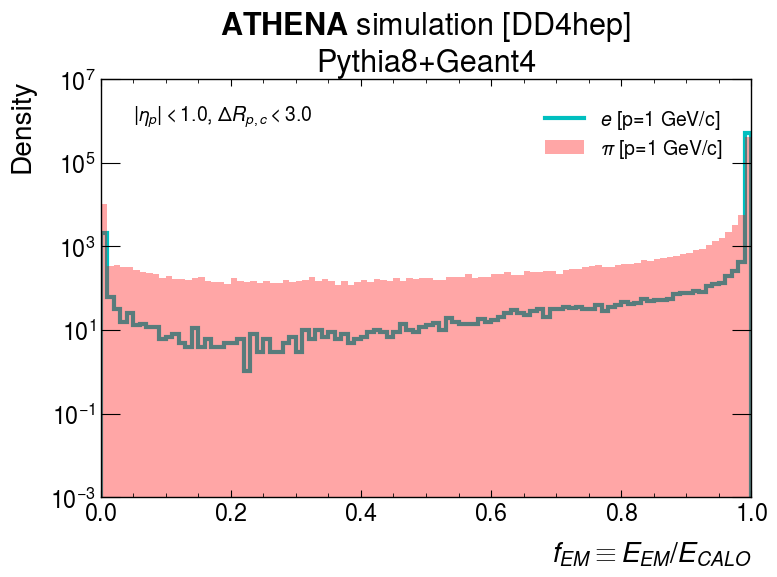

In [79]:
hep.histplot(hm.get_hist("eECALEnergyFraction"), hm.get_bins("eECALEnergyFraction"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergyFraction"), hm.get_bins("piECALEnergyFraction"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$f_{EM} \equiv E_{EM}/E_{CALO}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.05,1e6,"$|\eta_p| < 1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMFraction_e_vs_pi-G4.png", dpi=200)

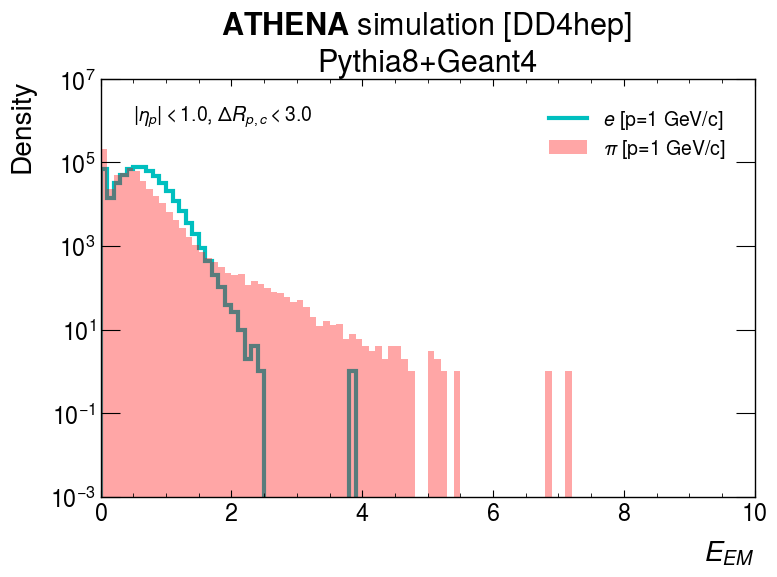

In [80]:
hep.histplot(hm.get_hist("eECALEnergy"), hm.get_bins("eECALEnergy"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergy"), hm.get_bins("piECALEnergy"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{EM}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e6,"$|\eta_p| < 1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMEnergy_e_vs_pi-G4.png", dpi=200)

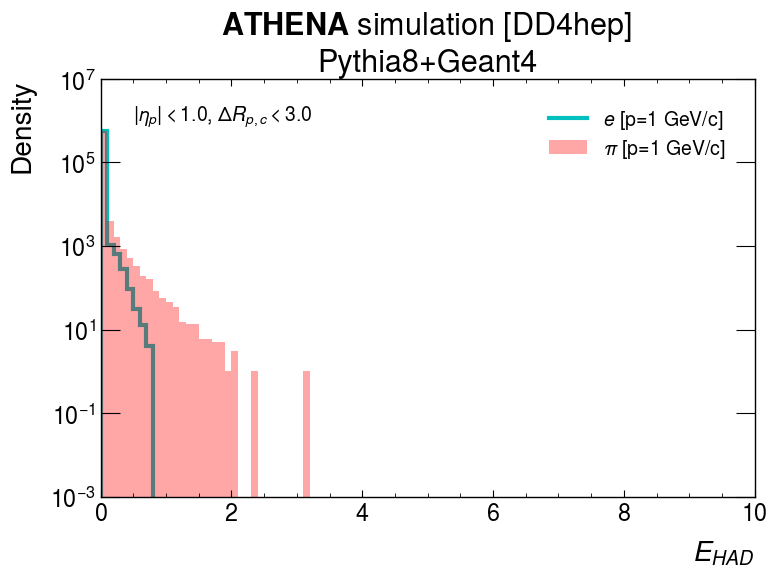

In [81]:
hep.histplot(hm.get_hist("eHCALEnergy"), hm.get_bins("eHCALEnergy"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piHCALEnergy"), hm.get_bins("piHCALEnergy"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{HAD}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e6,"$|\eta_p| < 1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("HADEnergy_e_vs_pi-G4.png", dpi=200)

my_kde = sns.kdeplot(data=df, x="ECALEnergyFraction", hue="PrimaryID",
   fill=True, common_norm=True, palette="dark",
   alpha=.7, linewidth=0, 
   bw_adjust=1, clip=[0,1]
)
plt.yscale("log")
plt.savefig("Barrel_ECALEnergyFraction_PDF_smoothed.png", dpi=200)


In [83]:
e_dens = sm.nonparametric.KDEUnivariate(df[df["PrimaryID"] == 11]["ECALEnergyFraction"])
pi_dens = sm.nonparametric.KDEUnivariate(df[df["PrimaryID"] == 211]["ECALEnergyFraction"])
e_dens.fit()
pi_dens.fit()
x = np.linspace(0,1,1000) #restrict range to (0,1)
el_y = e_dens.evaluate(x)
pi_y = pi_dens.evaluate(x)
#print(x,el_y,pi_y)

# Create array of arrays and write to disk
output_array = np.array([x,el_y,pi_y])
np.savetxt("EMEnergyRatios-Barrel.csv", output_array.T, delimiter = ",", header="ratio,e_density,pi_density")

# Backward Endcap Study

The samples below focus only on the backward endcap, the Crystal ECAL and the electron-side HCAL. Electrons and pions are only being generated at 5 GeV momentum and for angles from 90- to 175- degrees. I will focus on $\eta=[-3,-1]$.

In [85]:
# Load a single file and print the branches of the TTree
# file = uproot.open("EIC/reconstruction_benchmarks/rec_electron_1k-0.root")
# tree = file["events"]
# branches = tree.keys()
# for branch in branches:
#     if branch.find("Cluster") != -1:
#         print(branch)

In [4]:
sample_dir = "EIC/reconstruction_benchmarks/2021-06-19-HCAL-BAK-FWD"

e_files = {f"{sample_dir}/rec_electron_5k-p1000MEV-[0-9].root": "events", 
          f"{sample_dir}/rec_electron_5k-p1000MEV-[0-9][0-9].root": "events",
          f"{sample_dir}/rec_electron_5k-p1000MEV-1[0-9][0-9].root": "events"}
pi_files = {f"{sample_dir}/rec_pion+_5k-p1000MEV-[0-9].root": "events",
           f"{sample_dir}/rec_pion+_5k-p1000MEV-[0-9][0-9].root": "events",
           f"{sample_dir}/rec_pion+_5k-p1000MEV-1[0-9][0-9].root": "events"}

branches = ['EcalBarrelClusters.energy', 
            'EcalEndcapClusters.energy', 'HcalHadronEndcapClusters.energy', 'HcalElectronEndcapClusters.energy', 'CrystalEcalClusters.energy',
            'EcalBarrelClusters.polar.theta', 
            'EcalEndcapClusters.polar.theta', 'HcalHadronEndcapClusters.polar.theta', 'HcalElectronEndcapClusters.polar.theta', 'CrystalEcalClusters.polar.theta',
            'EcalBarrelClusters.polar.phi', 
            'EcalEndcapClusters.polar.phi', 'HcalHadronEndcapClusters.polar.phi', 'HcalElectronEndcapClusters.polar.phi', 'CrystalEcalClusters.polar.phi',
            'mcparticles2.pdgID', 'mcparticles2.genStatus',
            'mcparticles2.psx', 'mcparticles2.psy', 'mcparticles2.psz']

hm = HistManager()
hm.clear()

ProcessFiles(e_files, branches, hm, "e",  eta_range=[-3,-1], output_arrays=bak_data_arrays)
ProcessFiles(pi_files, branches, hm, "pi", eta_range=[-3,-1], output_arrays=bak_data_arrays)

Creating histogram named eECALEnergyFraction ... 
Creating histogram named eECALEnergy ... 
Creating histogram named eHCALEnergy ... 
Creating histogram named piECALEnergyFraction ... 
Creating histogram named piECALEnergy ... 
Creating histogram named piHCALEnergy ... 


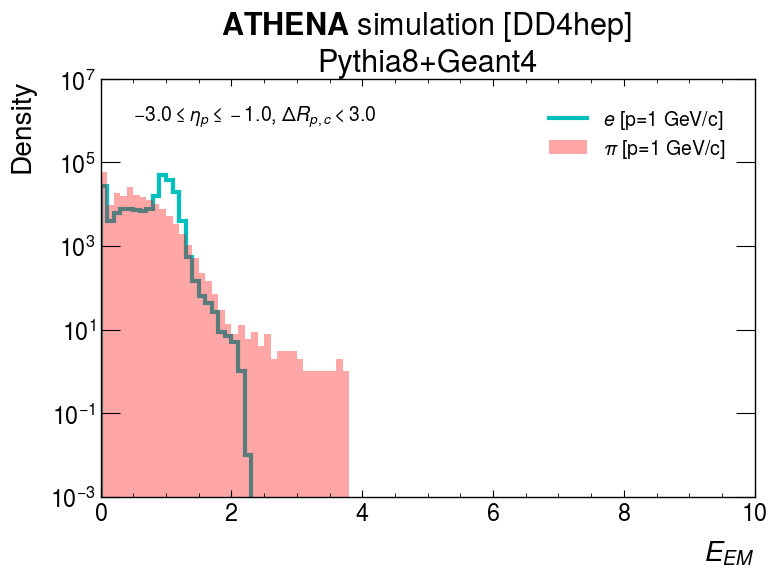

In [87]:
hep.histplot(hm.get_hist("eECALEnergy"), hm.get_bins("eECALEnergy"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergy"), hm.get_bins("piECALEnergy"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{EM}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e6,r"$-3.0 \leq \eta_p \leq -1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMEnergy_e_vs_pi-eta_-30_-10-G4.png", dpi=200)

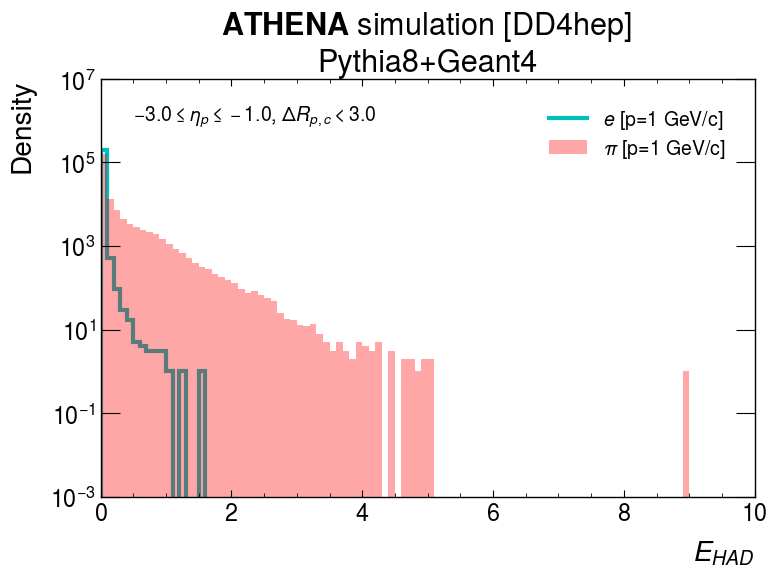

In [88]:
hep.histplot(hm.get_hist("eHCALEnergy"), hm.get_bins("eHCALEnergy"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piHCALEnergy"), hm.get_bins("piHCALEnergy"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{HAD}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e6,r"$-3.0 \leq \eta_p \leq -1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("HADEnergy_e_vs_pi-eta_-30_-10-G4.png", dpi=200)

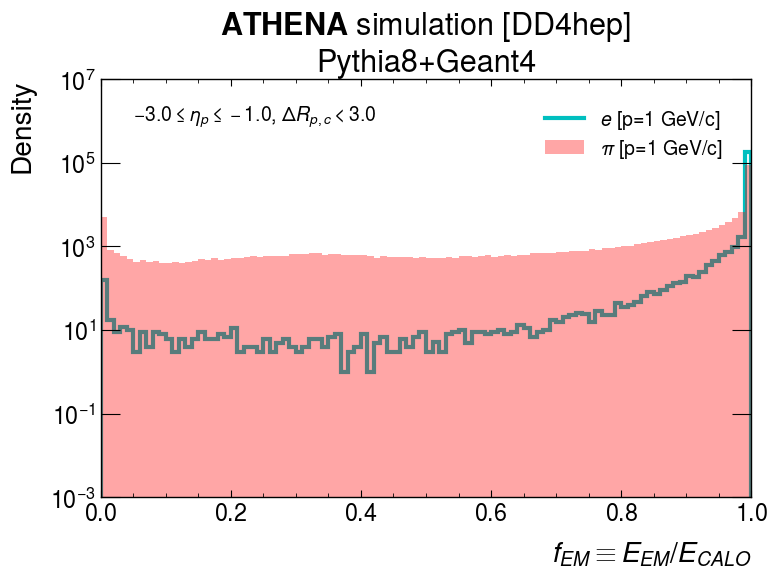

In [89]:
hep.histplot(hm.get_hist("eECALEnergyFraction"), hm.get_bins("eECALEnergyFraction"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergyFraction"), hm.get_bins("piECALEnergyFraction"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$f_{EM} \equiv E_{EM}/E_{CALO}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.05,1e6,r"$-3.0 \leq \eta_p \leq -1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMFraction_e_vs_pi-eta_-30_-10-G4.png", dpi=200)

    PrimaryID  ECALEnergyFraction  ECALEnergy  HCALEnergy  ElectronTheta  \
4        11.0                 1.0  956.961487         0.0       2.997590   
18       11.0                 1.0  977.082588         0.0       2.982734   
32       11.0                 1.0  973.782227         0.0       2.624715   
38       11.0                 1.0   44.515858         0.0       2.769375   
42       11.0                 1.0  943.286134         0.0       3.008583   

    ElectronPhi  ElectronIsoE  
4     -1.888450      4.739704  
18    -0.743376     76.233089  
32     1.052357      6.417135  
38    -2.684057     52.283969  
42    -0.021609     12.804114  


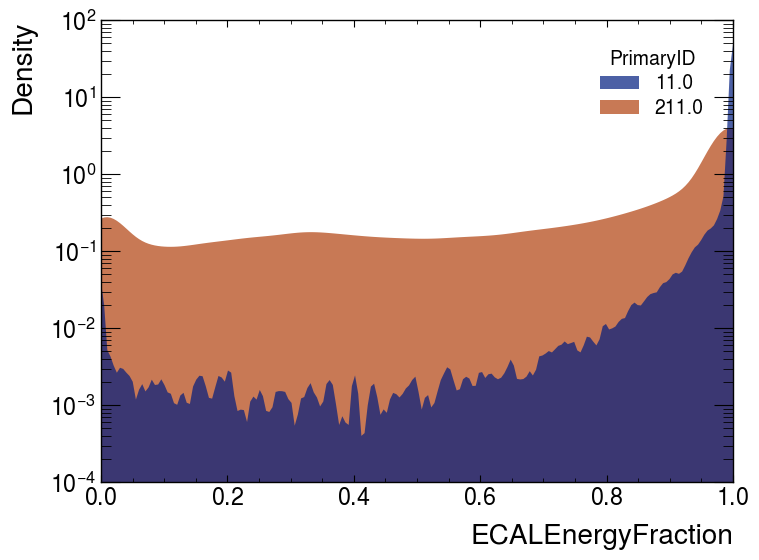

In [5]:
# Save the results of the file processing to a new dataframe for saving to disk
df = pd.DataFrame( bak_data_arrays, columns = bak_data_arrays.keys())
df = df[df["ECALEnergy"] + df["HCALEnergy"] > 0.0]
print(df.head())

my_kde = sns.kdeplot(data=df, x="ECALEnergyFraction", hue="PrimaryID",
   fill=True, common_norm=True, palette="dark",
   alpha=.7, linewidth=0, 
   bw_adjust=1, clip=[0,1]
)
plt.yscale("log")
plt.savefig("Backward_ECALEnergyFraction_PDF_smoothed.png", dpi=200)

e_dens = sm.nonparametric.KDEUnivariate(df[df["PrimaryID"] == 11]["ECALEnergyFraction"])
pi_dens = sm.nonparametric.KDEUnivariate(df[df["PrimaryID"] == 211]["ECALEnergyFraction"])
e_dens.fit()
pi_dens.fit()
x = np.linspace(0,1,1000) #restrict range to (0,1)
el_y = e_dens.evaluate(x)
pi_y = pi_dens.evaluate(x)
#print(x,el_y,pi_y)

# Create array of arrays and write to disk
output_array = np.array([x,el_y,pi_y])
np.savetxt("EMEnergyRatios-Backward.csv", output_array.T, delimiter = ",", header="ratio,e_density,pi_density")

# Forward Endcap Study

This part focuses on electrons and pions at 5 GeV/c fired into the forward endcap region, $\eta=[1,3]$.

In [6]:
sample_dir = "EIC/reconstruction_benchmarks/2021-06-19-HCAL-BRL-FWD"

e_files = {f"{sample_dir}/rec_electron_5k-p1000MEV-[0-9].root": "events", 
          f"{sample_dir}/rec_electron_5k-p1000MEV-[0-9][0-9].root": "events",
          f"{sample_dir}/rec_electron_5k-p1000MEV-1[0-9][0-9].root": "events"}
pi_files = {f"{sample_dir}/rec_pion+_5k-p1000MEV-[0-9].root": "events",
           f"{sample_dir}/rec_pion+_5k-p1000MEV-[0-9][0-9].root": "events",
           f"{sample_dir}/rec_pion+_5k-p1000MEV-1[0-9][0-9].root": "events"}

branches = ['EcalBarrelClusters.energy', 'HcalBarrelClusters.energy',
            'EcalEndcapClusters.energy', 'HcalHadronEndcapClusters.energy', 'HcalElectronEndcapClusters.energy', 'CrystalEcalClusters.energy',
            'EcalBarrelClusters.polar.theta', 'HcalBarrelClusters.polar.theta',
            'EcalEndcapClusters.polar.theta', 'HcalHadronEndcapClusters.polar.theta', 'HcalElectronEndcapClusters.polar.theta', 'CrystalEcalClusters.polar.theta',
            'EcalBarrelClusters.polar.phi', 'HcalBarrelClusters.polar.phi',
            'EcalEndcapClusters.polar.phi', 'HcalHadronEndcapClusters.polar.phi', 'HcalElectronEndcapClusters.polar.phi', 'CrystalEcalClusters.polar.phi',
            'mcparticles2.pdgID', 'mcparticles2.genStatus',
            'mcparticles2.psx', 'mcparticles2.psy', 'mcparticles2.psz']

hm = HistManager()
hm.clear()

ProcessFiles(e_files, branches, hm, "e", eta_range=[1,3], output_arrays=fwd_data_arrays)
ProcessFiles(pi_files, branches, hm, "pi", eta_range=[1,3], output_arrays=fwd_data_arrays)

Creating histogram named eECALEnergyFraction ... 
Creating histogram named eECALEnergy ... 
Creating histogram named eHCALEnergy ... 
Creating histogram named piECALEnergyFraction ... 
Creating histogram named piECALEnergy ... 
Creating histogram named piHCALEnergy ... 


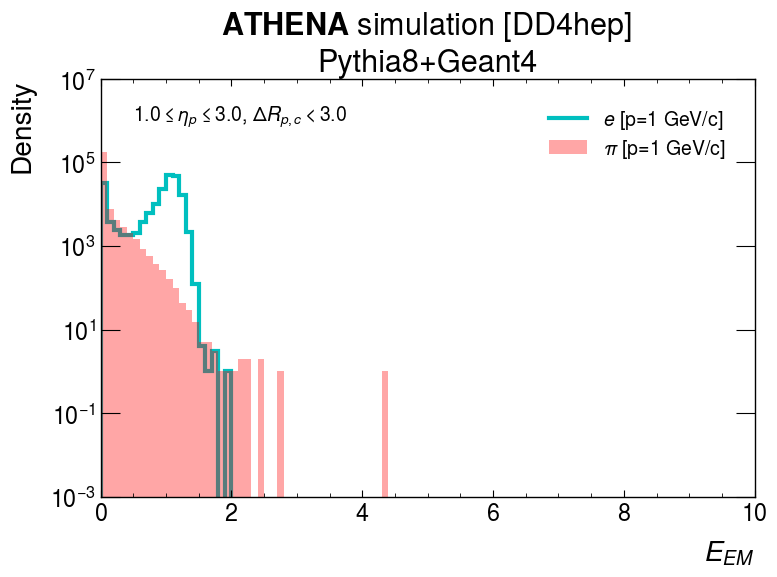

In [92]:
hep.histplot(hm.get_hist("eECALEnergy"), hm.get_bins("eECALEnergy"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergy"), hm.get_bins("piECALEnergy"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{EM}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e6,r"$1.0 \leq \eta_p \leq 3.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMEnergy_e_vs_pi-eta_10_30-G4.png", dpi=200)

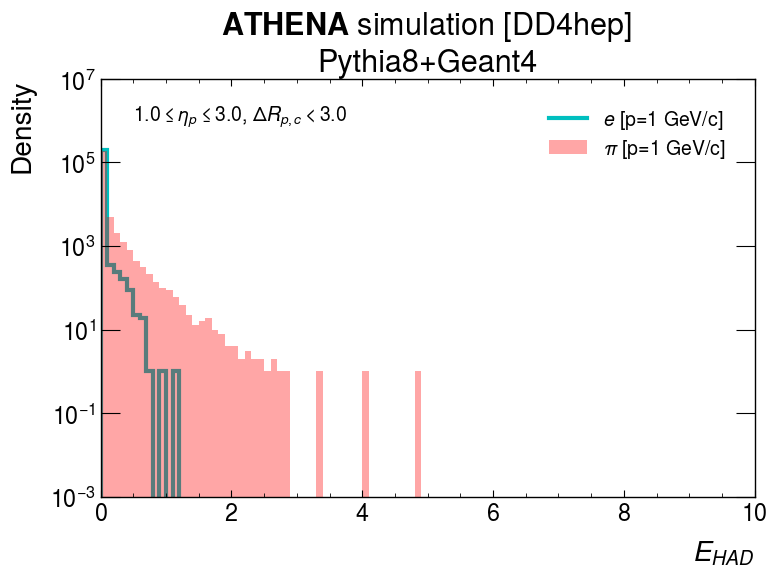

In [93]:
hep.histplot(hm.get_hist("eHCALEnergy"), hm.get_bins("eHCALEnergy"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piHCALEnergy"), hm.get_bins("piHCALEnergy"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{HAD}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e6,r"$1.0 \leq \eta_p \leq 3.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("HADEnergy_e_vs_pi-eta_10_30-G4.png", dpi=200)

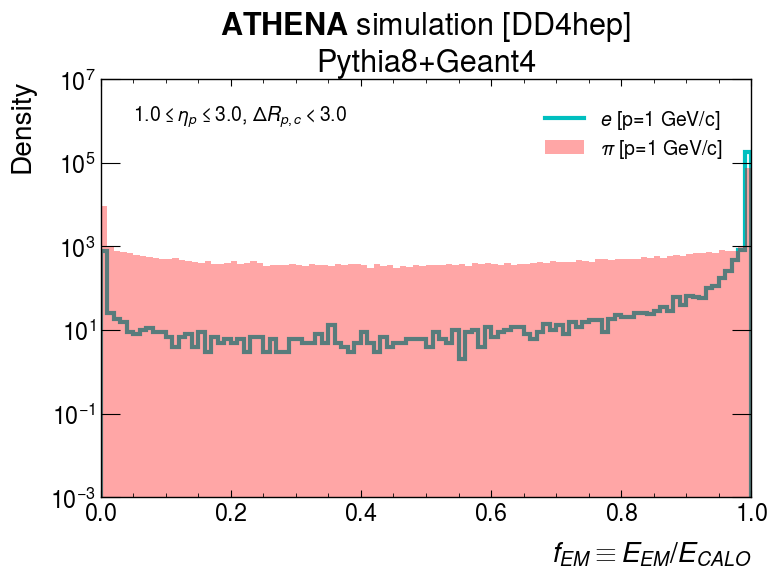

In [94]:
hep.histplot(hm.get_hist("eECALEnergyFraction"), hm.get_bins("eECALEnergyFraction"), label="$e$ [p=1 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergyFraction"), hm.get_bins("piECALEnergyFraction"), label="$\pi$ [p=1 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$f_{EM} \equiv E_{EM}/E_{CALO}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e7])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.05,1e6,r"$1.0 \leq \eta_p \leq 3.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMFraction_e_vs_pi-eta_10_30-G4.png", dpi=200)

    PrimaryID  ECALEnergyFraction   ECALEnergy  HCALEnergy  ElectronTheta  \
4        11.0                 1.0   727.216980         0.0       0.551325   
17       11.0                 1.0  1228.290283         0.0       0.102898   
21       11.0                 1.0   977.949707         0.0       0.392617   
25       11.0                 1.0  1129.114258         0.0       0.393943   
29       11.0                 1.0  1103.518066         0.0       0.279313   

    ElectronPhi  ElectronIsoE  
4     -1.334609    578.585537  
17     0.885145    178.648453  
21    -0.493999     22.743437  
25    -2.102663      7.985232  
29    -0.539821     26.440526  


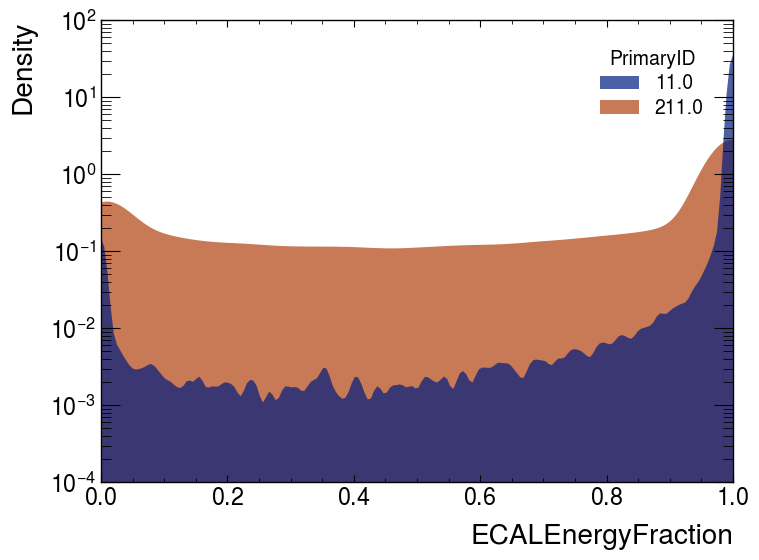

In [7]:
# Save the results of the file processing to a new dataframe for saving to disk
df = pd.DataFrame( fwd_data_arrays, columns = fwd_data_arrays.keys())
df = df[df["ECALEnergy"] + df["HCALEnergy"] > 0.0]
print(df.head())

my_kde = sns.kdeplot(data=df, x="ECALEnergyFraction", hue="PrimaryID",
   fill=True, common_norm=True, palette="dark",
   alpha=.7, linewidth=0, 
   bw_adjust=1, clip=[0,1]
)
plt.yscale("log")
plt.savefig("Forward_ECALEnergyFraction_PDF_smoothed.png", dpi=200)

e_dens = sm.nonparametric.KDEUnivariate(df[df["PrimaryID"] == 11]["ECALEnergyFraction"])
pi_dens = sm.nonparametric.KDEUnivariate(df[df["PrimaryID"] == 211]["ECALEnergyFraction"])
e_dens.fit()
pi_dens.fit()
x = np.linspace(0,1,1000) #restrict range to (0,1)
el_y = e_dens.evaluate(x)
pi_y = pi_dens.evaluate(x)
#print(x,el_y,pi_y)

# Create array of arrays and write to disk
output_array = np.array([x,el_y,pi_y])
np.savetxt("EMEnergyRatios-Forward.csv", output_array.T, delimiter = ",", header="ratio,e_density,pi_density")

# Save Information to a New ROOT File

In [41]:
import uproot3 as uproot3
output_file = uproot3.recreate("Electron_PID_CALO_Study.root")
output_file["tree"] = uproot3.newtree({"ECALEnergyFraction": np.float64,
                                       "ECALEnergy": np.float64,
                                       "HCALEnergy": np.float64,
                                       "PrimaryID": int,
                                      "ElectronTheta": np.float64,
                                      "ElectronPhi": np.float64,
                                      "ElectronIsoE": np.float64})
output_file["tree"].extend({"PrimaryID": df['PrimaryID'],
                           'ECALEnergyFraction': df['ECALEnergyFraction'],
                           'ECALEnergy': df['ECALEnergy'], 
                           'HCALEnergy': df['HCALEnergy'],
                           'ElectronTheta': df['ElectronTheta'],
                           'ElectronPhi': df['ElectronPhi'],
                           'ElectronIsoE': df['ElectronIsoE']})